In [1]:
!pip install transformers --quiet

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else "cpu"

In [3]:
data_df = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines = True)
data_df.dropna(inplace = True)
data_df.drop_duplicates(inplace = True)
data_df.head()
data_df.drop(['article_link'], inplace = True, axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size = 0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5)

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-08-13 06:12:14.312749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755065534.498637      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755065534.550832      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
class dataset(Dataset):
    def __init__(self, X,Y):
        self.X = [tokenizer(x, max_length = 100, truncation = True, padding = "max_length",return_tensors = "pt").to(device) for x in X]
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, indx):
        return self.X[indx], self.Y[indx]

training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test, Y_test)

In [5]:
batch_size = 32
epochs= 10
lr = 1e-4

train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(testing_data, batch_size = batch_size, shuffle = True)

class MyModel(nn.Module):
    def __init__(self, bert):
        super(MyModel, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

In [6]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = lr)

total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    for indx, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs.to(device)
        labels.to(device)
        prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()
        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for indx, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs.to(device)
            labels.to(device)
            prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()
            acc = (prediction.round() == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round((total_acc_train/training_data.__len__())*100, 4))
    total_acc_val_plot.append(round((total_acc_val/validation_data.__len__())*100, 4))  

    print(f"""Epoch no. {epoch+1}/{epochs}
            Training Loss: {round(total_loss_train/1000, 4)}
            Validation Loss: {round(total_loss_val/1000, 4)}
            Training Acc: {round((total_acc_train/training_data.__len__())*100, 4)}
            Validation Acc: {round((total_acc_val/validation_data.__len__())*100, 4)}""")

Epoch no. 1/10
            Training Loss: 0.2611
            Validation Loss: 0.0495
            Training Acc: 80.1123
            Validation Acc: 83.4498
Epoch no. 2/10
            Training Loss: 0.212
            Validation Loss: 0.0451
            Training Acc: 84.4076
            Validation Acc: 84.4483
Epoch no. 3/10
            Training Loss: 0.1992
            Validation Loss: 0.043
            Training Acc: 85.4293
            Validation Acc: 84.673
Epoch no. 4/10
            Training Loss: 0.1925
            Validation Loss: 0.0423
            Training Acc: 85.9053
            Validation Acc: 85.0724
Epoch no. 5/10
            Training Loss: 0.1882
            Validation Loss: 0.0422
            Training Acc: 86.1728
            Validation Acc: 85.6465
Epoch no. 6/10
            Training Loss: 0.185
            Validation Loss: 0.0459
            Training Acc: 86.4081
            Validation Acc: 83.999
Epoch no. 7/10
            Training Loss: 0.1819
            Validation Los

In [7]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for indx, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs.to(device)
        labels.to(device)
        prediction = model(inputs["input_ids"].squeeze(1), inputs ["attention_mask"].squeeze(1)).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_test += batch_loss.item()
        acc = (prediction.round() == labels).sum().item()
        total_acc_test += acc

print(f"Accuracy Score on testing Data is: {round((total_acc_test/testing_data.__len__())*100, 4)}")
        

Accuracy Score on testing Data is: 86.1742


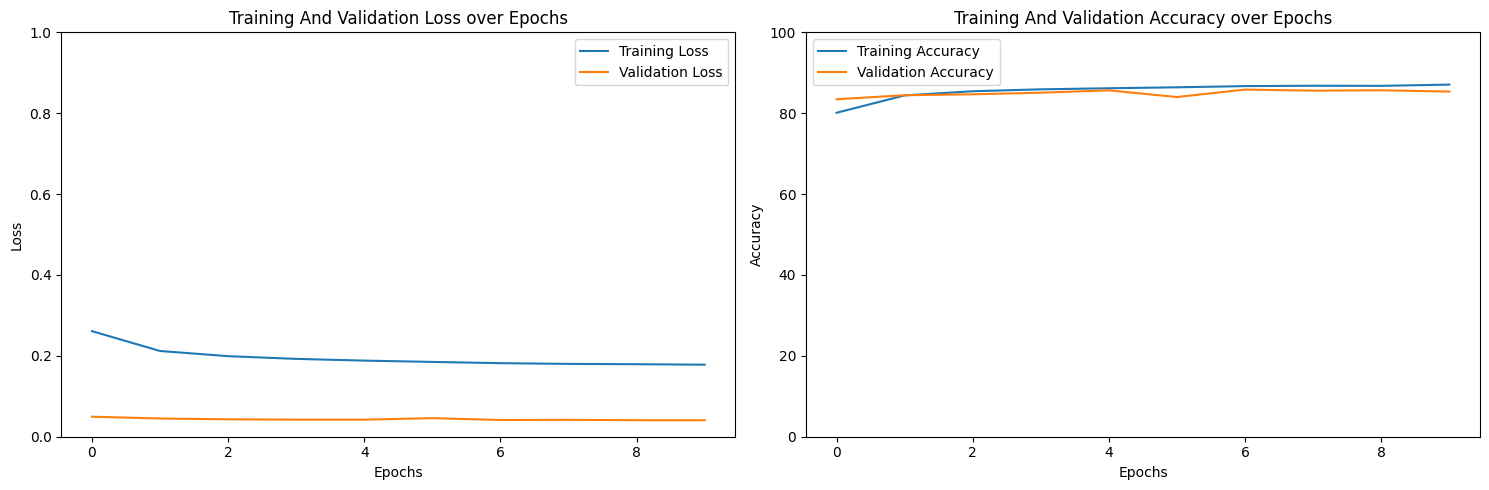

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_val_plot, label = "Validation Loss")
axs[0].set_title("Training And Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_val_plot, label = "Validation Accuracy")
axs[1].set_title("Training And Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.tight_layout()
plt.show()